In [15]:
from dask.distributed import Client

# remote Distributed Mode
# client = Client('tcp://192.168.2.100:8786')

# Local Multi-thread
# client = Client(processes=False, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Multi-Process
# client = Client(processes=True, threads_per_worker=2,
#                 n_workers=2, memory_limit='2GB')

# Local Single-Thread
client = None

In [16]:
"""
Active regression example with Gaussian processes.
"""

import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from dpyacl.core.misc.misc import split

# generating the data
X = np.random.choice(np.linspace(0, 20, 10000), size=200, replace=False).reshape(-1, 1)
y = np.sin(X) + np.random.normal(scale=0.3, size=X.shape)

# assembling initial training set
train_idx, test_idx, label_idx, unlabel_idx = split(
        X=X,
        y=y,
        test_ratio=0.3,
        initial_label_rate=0.05,
        split_count=1,
        all_class=True)

# defining the kernel for the Gaussian process
kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

# defying the learning technique using the gausian regressor
ml_technique = GaussianProcessRegressor(kernel)

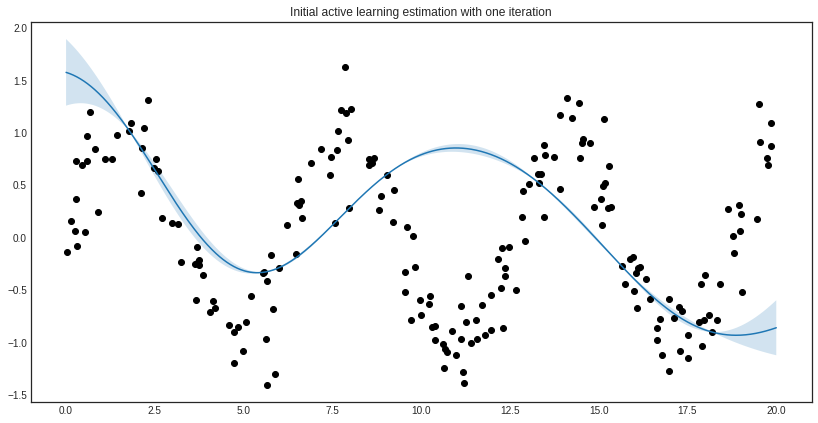

In [18]:
from dpyacl.experiment.context import HoldOutExperiment
from dpyacl.metrics.evaluation import Mse
from dpyacl.oracle import SimulatedOracle
from dpyacl.scenario.scenario import PoolBasedSamplingScenario
from dpyacl.strategies.single_label.error_reduction import QueryRegressionStd
from dpyacl.core.stop_criteria import MaxIteration
import matplotlib.pyplot as plt

# Experiment with one iteration
experiment = HoldOutExperiment(
        client=client,
        X=X,
        Y=y,
        scenario_type=PoolBasedSamplingScenario,
        train_idx=train_idx,
        test_idx=test_idx,
        label_idx=label_idx,
        unlabel_idx=unlabel_idx,
        ml_technique=ml_technique,
        performance_metrics=[Mse(squared=True)],
        query_strategy=QueryRegressionStd(),
        oracle=SimulatedOracle(labels=y),
        stopping_criteria=MaxIteration(1),
        self_partition=False,
        rebalance=True
    )

results = experiment.evaluate(verbose=False)
regressor = results[0].ml_technique

# plotting the initial estimation
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor.predict(x.reshape(-1, 1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, ) - std, pred.reshape(-1, ) + std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Initial active learning estimation with one iteration')
    plt.show()

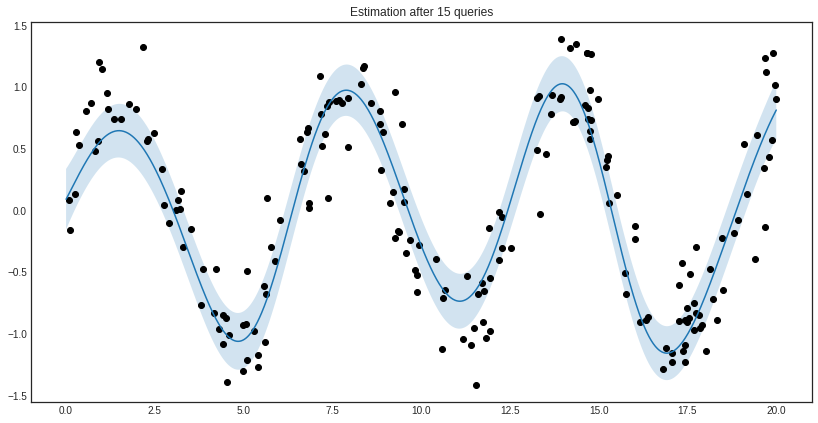

In [13]:
n_queries = 15
experiment2 = HoldOutExperiment(
    client=client,
    X=X,
    Y=y,
    scenario_type=PoolBasedSamplingScenario,
    train_idx=train_idx,
    test_idx=test_idx,
    label_idx=label_idx,
    unlabel_idx=unlabel_idx,
    ml_technique=ml_technique,
    performance_metrics=[Mse(squared=True)],
    query_strategy=QueryRegressionStd(),
    oracle=SimulatedOracle(labels=y),
    stopping_criteria=MaxIteration(n_queries),
    self_partition=False,
    rebalance=True
)

result2 = experiment2.evaluate(verbose=False)
regressor2 = result2[0].ml_technique

# plotting after active learning
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(14, 7))
    x = np.linspace(0, 20, 1000)
    pred, std = regressor2.predict(x.reshape(-1,1), return_std=True)
    plt.plot(x, pred)
    plt.fill_between(x, pred.reshape(-1, )-std, pred.reshape(-1, )+std, alpha=0.2)
    plt.scatter(X, y, c='k')
    plt.title('Estimation after %d queries' % n_queries)
    plt.show()